In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from cemba_data.tools.integration.utilities import calculate_direct_confusion
from ALLCools.plot import *
from ALLCools.plot.color import plot_colorbar

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

## Tidy data

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

In [5]:
name_map = {'LSX': 'TT*'}

regions = [
    'PFC', 'ACA', 'ORB', 'AI', 'MOs', 'MOp', 'SSp', 'SSs', 'PIR', 'AON'
]


cluster_order = [
    'PT-L5 Abca12',
    'PT-L5 Ptprt',
    'PT-L5 Unc5b',
    'PT-L5 Tenm2',
    'PT-L5 Astn2',
    'PT-L5 Plcb4',
    'PT-L5 Kcnh1',
    'PT-L5 Tmtc2',
    'PT-L5 Nectin1',
]
region_order = [
    'AON', 'PIR', 'TT*', 'PFC', 'ACA', 'ORB', 'AI', 'MOs', 'MOp', 'SSp', 'SSs',
    'Other'
]

sub_region_palette['TT*'] = '#ff7f0e'
sub_region_palette['Other'] = '#000000'

## Dot plot

In [6]:
count_data = cell_tidy_data[cell_tidy_data['MajorType'] == 'PT-L5'].groupby('SubType')['SubRegion'].value_counts()

records = {}
other_count = defaultdict(int)
for (cell_type, region), v in count_data.iteritems():
    if region in regions:
        records[(cell_type, region)] = v
    elif region in name_map:
        records[(cell_type, name_map[region])] = v
    else:
        other_count[(cell_type, 'Other')] += v
for (cell_type, region), v in other_count.items():
    records[(cell_type, region, v)] = v
count_data = pd.Series(records).unstack().fillna(0)
count_data.reindex(cluster_order)

ratio = (count_data / count_data.sum(axis=1).values[:, None]).unstack().reset_index()
ratio.columns = ['SubRegion', 'SubType', 'Ratio']

ratio['y'] = ratio['SubRegion'].map({v: i for i, v in enumerate(region_order)})
ratio['x'] = ratio['SubType'].map({v: i for i, v in enumerate(cluster_order)})

region_sum = count_data.sum(axis=0).astype(int).astype(str)
cluster_sum = count_data.sum(axis=1).astype(int).astype(str)

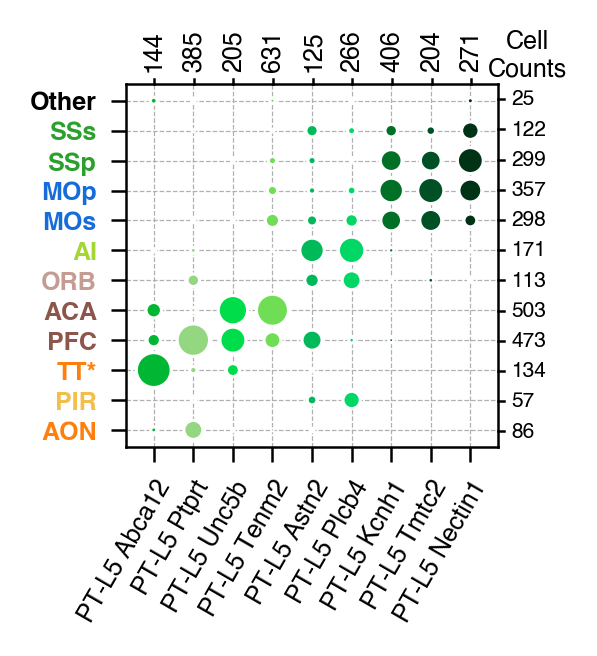

In [43]:
fig, ax = plt.subplots(figsize=(1.6, 1.6), dpi=300)

sns.scatterplot(ax=ax,
                data=ratio,
                x='x',
                y='y',
                hue='SubType',
                palette=sub_type_palette,
                size='Ratio',
                size_norm=(0., 1),
                sizes=(0, 100),
                zorder=10,
                clip_on=False)

ax.legend_.set_visible(False)
ax.set(xticks=range(len(cluster_order)),
       xticklabels=cluster_order,
       yticks=range(len(region_order)),
       yticklabels=region_order)

for tick in ax.xaxis.get_ticklabels():
    tick.set(rotation=60, rotation_mode='anchor', ha='right')
ax.grid(linewidth=0.3, linestyle='--')
ax.set(xlim=(-0.7, len(cluster_order)-0.3))
for ylabel in ax.yaxis.get_ticklabels():
    c = sub_region_palette[ylabel.get_text()]
    ylabel.set(color=c, fontweight='bold')

for i, (name, value) in enumerate(region_sum.reindex(region_order).iteritems()):
    y = i/len(region_order) + 0.042
    ax.text(1.035, y, value, 
            ha='left', va='center', transform=ax.transAxes, fontsize=labelsize-1)
    ax.plot((1, 1.015), (y, y), transform=ax.transAxes, c='k', clip_on=False)
    
for i, (name, value) in enumerate(cluster_sum.reindex(cluster_order).iteritems()):
    x = i/len(cluster_order) * 0.96 + 0.075
    ax.text(x, 1.035, value, rotation='90', rotation_mode='anchor',
            ha='left', va='center', transform=ax.transAxes, fontsize=labelsize)
    ax.plot((x, x), (1, 1.015), transform=ax.transAxes, c='k', clip_on=False)
    
ax.text(1.08, 1.08, 'Cell\nCounts', ha='center', va='center', 
        transform=ax.transAxes, fontsize=labelsize)
ax.set(xlabel='', ylabel='')


fig.savefig('PT-L5.spatial_dot_plot.pdf', bbox_inches='tight')
pass

## size bar

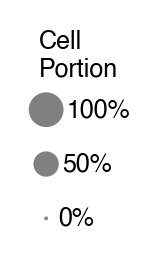

In [42]:
fig, sax = plt.subplots(figsize=(0.1, 0.6), dpi=300)

sax.scatter(x=[0.5, 0.5, 0.5],
            y=[0.1, 0.5, 0.9],
            s=[0.1, 30, 60],
            transform=sax.transAxes,
            c='gray',
            clip_on=False)
sax.axis('off')
sax.text(x=1., y=0.1, s='0%', transform=sax.transAxes, va='center', fontsize=labelsize)
sax.text(x=1.2, y=0.5, s='50%', transform=sax.transAxes, va='center', fontsize=labelsize)
sax.text(x=1.4, y=0.9, s='100%', transform=sax.transAxes, va='center', fontsize=labelsize)
sax.text(x=0.2, y=1.3, s='Cell\nPortion', ha='left',
         transform=sax.transAxes, va='center', fontsize=labelsize)
fig.savefig('PT-L5.spatial_dot_plot.legend.pdf', bbox_inches='tight')